In [180]:
import scipy.linalg as la
import numpy as np
import scipy.fftpack as fftpack
from tqdm import tqdm_notebook
from time import time

Stochastic Gradient Descent works very well; however, getting good performance from it usually involves hand-picking an annealing schedule. This takes time that could be spent improving other aspects of the model.

This motivates second order methods, which take into account curvature information of the loss surface. We would ideally like to use the Hessian, as it is the most natural way to express this. This leads to the Newton step. Suppose we are operating on gradients of dimension $p$, where $g_t = \nabla f(\beta_t)$ and $H_t = \nabla^2 f(\beta_t)$:

$$ \beta_{t + 1} = \beta_t - \alpha H_t^{-1} g_t $$

where $\alpha$ is selected by line search. This yields up to quadratic convergence. However, it is an extremely expensive operation, as we need to compute and store the Hessian, then compute its inverse. Even storing it is $O(p^2)$, which is infeasible for very large problems.

A natural refinement of the Newton step is to store an approximation of the inverse Hessian, $B_t$; this yields the BFGS method. In BFGS, an initial guess $B_1$ is supplied, and iteratively updated:

$$
\begin{align*}
s &= \beta_t - \beta_{t - 1}\\
y &= g_t - g_{t - 1}\\
B_{t + 1} &= \left( I - \frac{sy^T}{\langle y,s\rangle} \right) B_t \left( I - \frac{ys^T}{\langle y, s\rangle} \right) + \frac{ss^T}{\langle y,s\rangle}
\end{align*}
$$

This takes care of the inverse operation, but we are still storing a $p\times p$ matrix. L-BFGS instead stores a finite set of the $s$ and $y$ vectors, from which the descent direction $-B_tg_t$ can be computed iteratively. 

Another idea, introduced by Duchi et al. in "Adaptive Subgradient Methods for Online Learning and Stochastic Optimization", is derived from a different formulation of gradient information. Rather than use the Hessian, they chose to utilize the matrix of gradient outer products:

$$ G_t = \sum_{\tau = 1}^{t}{g_\tau g_\tau^T} $$

Then, the update step has the same spirit as the Newton step, with $H_t$ being replaced with $G_t$:

$$ \beta_{t + 1} = \beta_t - \eta G_t^{-1/2} g_t $$



In [328]:
def AdaFull(eta, delta, T, f, fgrad, beta):
    start = time()
    p = beta.shape[0]
    G = np.zeros((p, p))
    losses = []
    for t in range(T):
        g = fgrad(beta)
        G = G + np.outer(g, g)
        # compute inverse square root
        U, s, V = np.linalg.svd(G, full_matrices=False)
        beta = beta - eta * U @ (1 / (np.sqrt(s) + delta) * (V @ g))
        losses.append(f(beta))
    
    return beta, losses, G, time() - start

where $\eta$ is a hyperparameter. Unfortunately, we are back in expensive territory because of the inverse. To deal with this, they instead use the approximation which they call AdaGrad:

$$ \beta_{t + 1} = \beta_t - \eta \operatorname{diag}(G_t)^{-1/2} g_t $$

This has the advantage of linear storage and computation. 

In [ ]:
def AdaGrad(eta, delta, T, f, fgrad, beta):
    start = time()
    p = beta.shape[0]
    G = np.zeros(p)
    
    losses = []
    
    for t in range(T):
        g = fgrad(beta)
        G = G + (g * g)
        beta = beta - eta * (g / np.sqrt(G) + delta)
        
        losses.append(f(beta))
        
    return beta, losses, G, time() - start

The question of AdaGrad is whether it is reasonable to take the diagonal of $G_t$ as an approximation. This would require the non-diagonal entries to be very small, relative to the diagonal, i.e. $ i\neq j, \sum_{\tau=1}^{t}{g_{\tau,i}g_{\tau,j}} \approx 0$. There are a couple possible reasons this would be the case. It could be that the sign of $g_{\tau,i}g_{\tau,j}$ flips from one iteration to another (i.e. the different components of the gradient are uncorrelated), or the gradients could be sparse, in which case w.h.p. $g_{\tau,i}g_{\tau,j}$ is exactly zero. What about the cases where this does not hold? This is the hole that "Scalable Adaptive Stochastic Optimization Using Random Projections" addresses.

Whereas AdaGrad requires an assumption about the nature of the gradients because its approximation is fixed, the algorithms in this paper utilize random approximations. The problem with using AdaFull is largely in the inverse square root operation. This is a $O(p^3)$ operation, infeasible for even modest problems. We would like to operate on a much smaller matrix that captures most of the action in $G_t$.

The approximation that the authors choose is described in "Finding Structure with Randomness: Probabalistic Algorithms for Constructing Approximate Matrix Decompositions". It is composed of two parts:
1. Draw an $p\times \tau$ SRFT test matrix $\Omega$
2. Form the $p\times \tau$ matrix $Y = A\Omega$ using a subsampled FFT
3. Construct an $p\times \tau$ matrix $Q$ whose columns form an orthonormal basis for the range of $Y$, e.g., using the QR factorization $Y = QR$
4. Form the matrix $B = Q^T A$
5. Compute an SVD of the small matrix $B = \tilde{U}\Sigma V^T$
6. Form the orthonormal matrix $U = Q\tilde{U}$

Here, the SRFT is defined as the product $\Omega = \sqrt{\frac{p}{\tau}} DFR$, where $D$ is a diagonal matrix whose entries are selected randomly from $\{-1, 1\}$, $F$ is the discrete cosine transform, and $R$ is the top $\tau$ rows of a permutation of the $p\times p$ identity matrix.


In [ ]:
# prototypical srft function; don't actually use because it's really inefficient
def sample_srft(n, l):
    R = np.zeros((n, l))
    indices = np.random.permutation(range(n))
    for i, j in enumerate(indices[:l]):
        R[j, i] = 1
    D = np.diag(np.random.choice((-1, 1), n))
    return np.sqrt(n / l) * D @ fftpack.dctn(R, norm='ortho')

def srft_vector_multiply(g, tau):
    """Left multiply a vector by a SRFT"""
    p = g.shape[0]
    # randomly sample tau elements of g
    r = np.random.choice(np.arange(p), tau, replace=False)
    g = g[r]
    # compute dct
    g = fftpack.dct(g, norm='ortho')
    # randomly and independently multiply elements of g by 1 or -1
    g = g * np.random.choice((-1, 1), tau)
    return np.sqrt(p / tau) * g

def srft_matmul(G, tau):
    """Right multiply a matrix by a SRFT"""
    p = G.shape[0]
    # multiply each column of G by (1, -1)
    d = np.random.choice((-1, 1), p)
    G = np.einsum("ij,j->ij", G, d)
    
    # dct of subsampling matrix
    R = np.zeros((p, tau))
    r = np.random.choice(np.arange(p), tau, replace=False)
    for j, i in enumerate(r):
        R[i, j] = 1
        
    return np.qrt(p / tau) * G @ fftpack.dctn(R, norm='ortho')    

Once we have the SVD, computing the inverse square root is a trivial elementwise operation on $\Sigma$. Conveniently, if $Q$ satisfies $\lVert A - QQ^TA\rVert \leq \varepsilon$ (spoiler: it does) the SVD satisfies $\lVert A - U\Sigma V^T\rVert \leq \varepsilon$. Thus, the update for the first algorithm, AdaLR, is the following:

$$ \beta_{t + 1} = \beta_t - \eta V \left(\Sigma^{1/2} + \delta I\right)^{-1} V^T g_t $$

The symmetry of $G_t$ justifies the final left multiplication by $V$ rather than $U$. The most expensive $O(p^3)$ step of AdaFull is reduced to $O(\tau p^2)$, where $\tau$ is a hyperparameter that controls the accuracy-time tradeoff.

In [329]:
def AdaLR(eta, delta, tau, T, f, fgrad, beta):
    start = time()
    
    p = beta.shape[0]
    G = np.zeros((p, p))
    #Pi = sample_srft(p, tau)
    
    losses = []
    for t in range(T):
        # receive gradient
        g = fgrad(beta)
        # update gradient matrix
        G = G + np.outer(g, g)
        
        # construct approximate range of G
        # random projection
        # Gproj = G @ Pi
        Gproj = srft_matmul(G, tau)
        # QR decomposition
        Q, R = np.linalg.qr(Gproj)
        
        # approximate SVD using approximate range
        B = Q.T @ G
        U, s, VT = np.linalg.svd(B, full_matrices=False)
                
        # update
        direction = VT.T @ ((1 / (np.sqrt(s) + delta) * (VT @ g)))
        beta = beta - eta * direction
        
        losses.append(f(beta))

    return beta, losses, G, time() - start

Though AdaLR reduces the complexity of the inverse square root, note that it still initially operates on the full $p\times p$ $G_t$. We are still stuck with quadratic storage as well as quadratic costs in updating the gradient matrix, randomly projecting the gradient matrix to find approximate range, and projecting the gradient matrix onto the approximate range.

The authors further refine AdaLR, eliminating these quadratic costs, in their RadaGrad algorithm. Instead of storing the full matrix $G_t$ and then projecting it, it only stores the $\tau\times p$ approximate gradient matrix $\tilde{G}_t$, and updates it with $g_t g_t^T \Pi$. These improvements give RadaGrad a cost of $O(\tau^2p)$.

In [330]:
def RadaGrad(eta, delta, tau, T, f, fgrad, beta):
    start = time()
    p = beta.shape[0]
    Gtilde = np.zeros((p, tau))
    # Pi = sample_srft(p, tau)
    Q = np.eye(p, tau)
    R = np.zeros((tau, tau))
    
    losses = []
    
    for t in range(T):
        # receive gradient
        g = fgrad(beta)
        # project gradient
        # gtilde = Pi.T @ g
        gtilde = srft_vector_multiply(g, tau)
        # update approximate gradient matrix
        Gtilde = Gtilde + np.outer(g, gtilde)
        # rank-1 qr update
        Q, R = la.qr_update(Q, R, g, gtilde)
        # Q, R = np.linalg.qr(Gtilde)
        # compute approximate range, then compute approximate SVD
        B = Gtilde.T @ Q
        U, s, WT = np.linalg.svd(B, full_matrices=False)
        V = Q @ WT
        
        # correction term when low-rank assumption does not hold
        gamma = eta * (g - V @ (V.T @ g))
        # update
        beta = beta - eta * V @ ((1 / (np.sqrt(s) + delta)) * (V.T @ g)) - gamma
        
        losses.append(f(beta))
    return beta, losses, Gtilde, time() - start

I implemented a couple of possible improvements of the two algorithms. What if AdaGrad and AdaLR were combined? Could we gain the advantages of both algorithms? I call this algorithm AdaLR. Its update is of the form

$$ 
\begin{align*}
\nu_D &= (\operatorname{diag}(G_t)^{1/2} + \delta I)^{-1}g_t\\
\nu_R &= V(\Sigma^{1/2} + \delta I)^{-1}g_t\\
\beta_{t + 1} &= \beta_t - \eta(\nu_D + \nu_R)
\end{align*}
$$

It has no additional parameters, as a benefit of its simplicity. 


In [332]:
def AdaLR_Diag(eta, delta, tau, T, f, fgrad, beta):
    start = time()
    
    p = beta.shape[0]
    G = np.zeros((p, p))
    # Pi = sample_srft(p, tau)
    
    losses = []
    for t in range(T):
        # receive gradient
        g = fgrad(beta)
        # update gradient matrix
        G = G + np.outer(g, g)
        
        # construct approximate range of G
        # random projection
        # Gproj = G @ Pi
        Gproj = srft_matmul(G, tau)
        # QR decomposition
        Q, R = np.linalg.qr(Gproj)
        
        # approximate SVD
        B = Q.T @ G
        U, s, VT = np.linalg.svd(B, full_matrices=False)
        
        # update
        # AdaLR direction
        random_direction = VT.T @ ((1 / (np.sqrt(s) + delta) * (VT @ g)))
        # AdaGrad direction
        diag_direction = g / (np.sqrt(np.diag(G)) + delta)
        beta = beta - eta*random_direction - eta*diag_direction
        
        losses.append(f(beta))
        
    return beta, losses, G, time() - start

The other question is this: what if we were to add an exponential forgetting scheme, like Adam or RMSprop? This addition is also easy to implement. The only difference is in the gradient matrix update:

$$ \tilde{G}_t = \alpha \tilde{G}_t + (1 - \alpha) g_t \tilde{g}_t^T $$

where $\alpha$ is a hyperparameter close to 1.

In [301]:
def RadaForget(eta, delta, tau, alpha, T, f, fgrad, beta):
    start = time()
    
    p = beta.shape[0]
    Gtilde = np.zeros((p, tau))
    # Pi = sample_srft(p, tau)
    Q = np.eye(p, tau)
    R = np.zeros((tau, tau))
    
    losses = []
    
    for t in range(T):
        # receive gradient
        g = fgrad(beta)
        # project gradient
        # gtilde = Pi.T @ g
        gtilde = srft_vector_multiply(g, tau)
        # update approximate gradient matrix
        Gtilde = alpha*Gtilde + (1-alpha)*np.outer(g, gtilde)
        # rank-1 qr update
        # Q, R = la.qr_update(Q, R, g, gtilde)
        Q, R = np.linalg.qr(Gtilde)
        # compute approximate range, then compute approximate SVD
        B = Gtilde.T @ Q
        U, s, WT = np.linalg.svd(B, full_matrices=False)
        V = Q @ WT
        
        # correction term when low-rank assumption does not hold
        gamma = eta * (g - V @ (V.T @ g))
        # update
        beta = beta - eta * V @ ((1 / (np.sqrt(s) + delta)) * (V.T @ g)) - gamma
        
        losses.append(f(beta))
    return beta, losses, Gtilde, time() - start

$$ B_{t+1} = B_t + \frac{\langle s_t,y_t\rangle + y_t^T B_t y_t}{\langle s_t,y_t \rangle}s_ts_t^T - \frac{B_t y_t s_t^T + s_t y_t B_t}{\langle s_t, y_t\rangle} $$

In [545]:
def btls(f, fgrad, x, d, c, beta):
    alpha = 1
    while f(x + alpha * d) > f(x) + c*alpha*np.inner(fgrad(x), d):
        alpha = beta * alpha
    return alpha

def LBFGS(f, fgrad, T, x, m, c, beta_ls):
    start = time()
    
    p = x.shape[0]
    
    losses = []
    
    g = fgrad(x)
    
    y_hist = [g]
    s_hist = [x]
    
    for t in range(T):                
        # compute descent direction
        q = g
        m2 = min(m, len(y_hist)) # true length
        
        alphas = np.zeros(m2)
        for i in range(m2 - 1, 1, -1):
            rho = 1 / np.dot(y_hist[i - 1], s_hist[i - 1])
            alphas[i - 1] = rho * np.dot(s_hist[i - 1], q)
            q = q - np.dot(alphas[i - 1], y_hist[i - 1])
        gamma = np.dot(s_hist[m2 - 2], y_hist[m2 - 2]) / \
                    np.dot(y_hist[m2 - 2], y_hist[m2 - 2])
        z = -gamma * q
        for i in range(1, m2 - 1):
            rho = 1 / np.dot(y_hist[i - 1], s_hist[i - 1])
            beta = rho * np.dot(y_hist[i - 1], z)
            z = z + s_hist[i - 1] * (alphas[i - 1] - beta)
            
        # find step size
        alpha = btls(f, fgrad, x, z, c, beta_ls)
        
        # update
        # print(alpha * z)
        xnext = x + alpha * z
        #xnext = x + z
        s_hist.append(xnext - x)
        x = xnext
        
        gnext = fgrad(x)
        y_hist.append(gnext - g)
        g = gnext       
        
        if len(s_hist) > m:
            s_hist.pop(0)
        if len(y_hist) > m:
            y_hist.pop(0)
        
        losses.append(f(x))
    return x, losses, time() - start

beta_T_lbfgs, losses_lbfgs, time_lbfgs = LBFGS(loss, lossgrad, 50, beta_0, 10, 0.2, 0.8)

# Experiments
## Low Rank Dense Data

We will simulate low-rank dense data using the sklearn `make_classification` function

In [80]:
from autograd import grad
import autograd.numpy as np
from tqdm import tqdm_notebook

n = 10000
p = 250

eta_range = [0.001, 0.01, 0.1, 1, 10]
delta = 1e-8
tau_range = [10, 20, 40]
T = 1000
beta_0 = np.ones(p)

def log_loss(yhat, y, eps=1e-15):
    yhat = np.clip(yhat, eps, 1 - eps)
    return -(np.inner(y, np.log(yhat)) + np.inner(1 - y, np.log(1 - yhat))) / y.shape[0]

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=n, n_features=p)
def make_loss(X, y):
    def loss(beta):
        return log_loss(X @ beta, y)
    return loss

loss = make_loss(X, y)
lossgrad = grad(loss)

In [320]:
# AdaFull
adafull_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    beta_T_adafull, losses_adafull, G, elapsed = AdaFull(eta, delta, T, loss, lossgrad, beta_0)
    if losses_adafull[-1] < adafull_best['loss_best']:
        adafull_best = {
            'loss_best': losses_adafull[-1],
            'losses': losses_adafull,
            'beta': beta_T_adafull,
            'eta': eta,
            'G': G,
            'elapsed': elapsed
            }
adafull_best

{'loss_best': 2.6145936889080117,
 'losses': [16.160508067206976,
  15.774577872223727,
  15.555399678197015,
  15.297476960242461,
  15.068481318954309,
  14.832883425191271,
  14.460941066904532,
  14.21777556041559,
  13.9752664670792,
  13.86658801200904,
  13.525510944731865,
  13.317248504308331,
  13.039485446184708,
  12.863033612015617,
  12.777298454792522,
  12.60421871338384,
  12.449926770435185,
  12.243401737806987,
  12.12811443519271,
  12.0484351677887,
  11.823029422740325,
  11.675007486893596,
  11.626238196396487,
  11.458949804638017,
  11.201040780534283,
  11.017975597900625,
  10.850279207580686,
  10.800722872820863,
  10.670858885973335,
  10.644774300534241,
  10.53048121502361,
  10.329181432996824,
  10.1366517332902,
  10.04646392677986,
  9.846245260571441,
  9.709800874624998,
  9.665199849463603,
  9.456910603572666,
  9.297468961510642,
  9.14144765982754,
  8.982065559548571,
  8.76258242782463,
  8.653876314430184,
  8.511690305069337,
  8.39034839

In [310]:
# AdaGrad
adagrad_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    beta_T_adagrad, losses_adagrad, G, elapsed = AdaGrad(eta, delta, T, loss, lossgrad, beta_0)
    if losses_adagrad[-1] < adagrad_best['loss_best']:
        adagrad_best = {
            'loss_best': losses_adagrad[-1],
            'losses': losses_adagrad,
            'beta': beta_T_adagrad,
            'eta': eta,
            'G': G,
            'elapsed': elapsed
            }
adagrad_best

{'loss_best': 8.47399242278319,
 'losses': [15.794262969334586,
  15.251125315844783,
  14.96028189100294,
  14.815920900603896,
  14.634233951147905,
  14.292956628846014,
  14.232768505351606,
  13.731714757484728,
  13.550091998319479,
  13.775255753487134,
  13.639394255686563,
  13.517132416633656,
  13.348096615847515,
  13.247378420388916,
  13.150172826999949,
  13.124963905490993,
  12.981412831836208,
  12.861413176809908,
  12.6355658404928,
  12.606985796591546,
  12.556651356618007,
  12.325221126743251,
  12.263715454068057,
  12.182270053482785,
  12.261583622668734,
  12.100159868005182,
  12.008708821399793,
  11.977679508916324,
  12.03893505431629,
  11.959395104319984,
  11.887460278166737,
  11.823390344760556,
  11.80427851215432,
  11.750559107102413,
  11.685937138798355,
  11.653293455023494,
  11.624088482788018,
  11.56246690729514,
  11.53147618916709,
  11.465661540179402,
  11.40291059487768,
  11.316348381000253,
  11.337165379358613,
  11.24813408936137,

In [311]:
# AdaLR
adalr_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    for tau in tau_range:
        beta_T_adalr, losses_adalr, G, elapsed = AdaLR(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_adalr[-1] < adalr_best['loss_best']:
            adalr_best = {
                'loss_best': losses_adalr[-1],
                'losses': losses_adalr,
                'beta': beta_T_adalr,
                'tau': tau,
                'eta': eta,
                'G': G,
                'elapsed': elapsed
            }
adalr_best

{'loss_best': 3.2480984962585717,
 'losses': [16.160508066825464,
  15.77457786298744,
  15.555400249172317,
  15.300380819431567,
  15.089534102148649,
  14.822033806805866,
  14.595797301046746,
  14.432002398327391,
  14.450356419327965,
  14.363599574558684,
  14.108142109272013,
  13.903215439023345,
  13.627263032604484,
  13.348585765699362,
  13.043271970189995,
  12.818586992984036,
  12.629515247509616,
  12.497246750815385,
  12.272104030156624,
  12.067304052919003,
  11.870097210410702,
  11.667018155236015,
  11.602601995483603,
  11.482908496498544,
  11.276486142602865,
  11.1554110325428,
  10.987465787177664,
  10.919488579097457,
  10.914767317453387,
  10.649740160304116,
  10.703469403305114,
  10.594816256822492,
  10.487359896653283,
  10.224137254411943,
  10.124159461873532,
  9.91038495567042,
  9.665938635938492,
  9.564386671521012,
  9.490984605269931,
  9.475682664375583,
  9.271818484836055,
  9.123829378184737,
  8.9342185284628,
  8.776023522746502,
  8

In [312]:
# RadaGrad
radagrad_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    for tau in tau_range:
        beta_T_radagrad, losses_radagrad, Gtilde, elapsed = RadaGrad(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_radagrad[-1] < radagrad_best['loss_best']:
            radagrad_best = {
                'loss_best': losses_radagrad[-1],
                'losses': losses_radagrad,
                'beta': beta_T_radagrad,
                'tau': tau,
                'eta': eta,
                'Gtilde': Gtilde,
                'elapsed': elapsed
            }
radagrad_best

ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


{'loss_best': 3.0394256760292233,
 'losses': [16.372939808539666,
  16.19684839704999,
  16.029385083094517,
  15.88895752245503,
  15.697551233866223,
  15.542494145895116,
  15.37253956442599,
  15.333864172119519,
  15.35556620365893,
  15.222034340846148,
  15.0338232910821,
  15.014038517424767,
  14.889617597406195,
  14.770794137873297,
  14.657585640577075,
  14.597000948631967,
  14.701435096351206,
  14.371709176524117,
  14.142531350705587,
  14.013405103190104,
  13.86021736614045,
  13.915473177825612,
  13.890434052019886,
  13.762058482521137,
  13.619960222340369,
  13.510244821525976,
  13.31632235059354,
  13.347677607565565,
  13.220818799893342,
  13.186409183654565,
  12.907239680777112,
  12.985786847437408,
  12.82698682531967,
  12.572933405835112,
  12.444983593982455,
  12.164538785189183,
  12.132614814752715,
  11.999116736740211,
  11.746335664511449,
  11.612259255005736,
  11.598688282184032,
  11.399683238943155,
  11.20619512694336,
  11.115949435141362

In [313]:
# AdaLR+Diag
adalr_diag_best = {
    'loss_best': float('inf')
}
for eta in eta_range:
    print(eta)
    for tau in tau_range:
        beta_T_adalr_diag, losses_adalr_diag, G, elapsed = AdaLR_Diag(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_adalr_diag[-1] < adalr_diag_best['loss_best']:
            adalr_diag_best = {
                'loss_best': losses_adalr_diag[-1],
                'losses': losses_adalr_diag,
                'beta': beta_T_adalr_diag,
                'tau': tau,
                'eta': eta,
                'G': G,
                'elapsed': elapsed
            }
adalr_diag_best

0.001
0.01
0.1
1
10


{'loss_best': 5.2810253673925365,
 'losses': [15.544342790770793,
  14.65859409348157,
  14.283725782595662,
  13.921209421597025,
  13.854784573918097,
  13.697021139437956,
  13.36881700882495,
  13.073210427394978,
  12.874193217318311,
  12.58200736609645,
  12.495434233863474,
  12.442094567273214,
  12.234895339779998,
  12.479795193964343,
  12.141101121816742,
  12.056334722538354,
  11.855530834744677,
  11.708371099470655,
  11.692854571527322,
  11.565328320447659,
  11.507077713486362,
  11.358154801764575,
  11.219928924190318,
  11.01709326780418,
  10.899214423045834,
  11.040461014569246,
  10.87125044352325,
  10.71872198926135,
  10.593035682639902,
  10.464755284389316,
  10.38207510290013,
  10.326030112405766,
  10.21801600396685,
  10.114239919346417,
  10.029628350464767,
  9.928178489346646,
  9.748994833226085,
  9.668431033389407,
  9.565202696859988,
  9.489999953181625,
  9.421904958685207,
  9.28897981839111,
  9.187021180436123,
  9.073477575006555,
  9.00

In [314]:
# RadaForget
radaforget_best = {
    'loss_best': float('inf')
}
alpha_range = [0.9, 0.99, 0.999]
for eta in eta_range:
    print(eta)
    for tau in tau_range:
        for alpha in alpha_range:
            beta_T_radaforget, losses_radaforget, Gtilde, elapsed = RadaForget(eta, delta, tau, alpha, T, loss, lossgrad, beta_0)
            if losses_radaforget[-1] < radaforget_best['loss_best']:
                radaforget_best = {
                    'loss_best': losses_radaforget[-1],
                    'losses': losses_radaforget,
                    'beta': beta_T_radaforget,
                    'tau': tau,
                    'eta': eta,
                    'alpha': alpha,
                    'Gtilde': Gtilde,
                    'elapsed': elapsed
                }
radaforget_best

0.001
0.01
0.1
1
10


{'loss_best': 2.363719298036079,
 'losses': [16.44040942614755,
  16.32536919389993,
  16.154162117979507,
  16.12626241444025,
  16.007267273129344,
  15.92900830211743,
  15.919901166888874,
  15.768101567193746,
  15.660823565064085,
  15.469403220292058,
  15.438581343478559,
  15.221947979394725,
  15.228580601877452,
  15.18693446535755,
  14.999297863743516,
  14.953258903508058,
  14.907449852136807,
  14.833733709992067,
  14.781724082194485,
  14.735860044568117,
  14.62183194835111,
  14.564034245197679,
  14.475701364345001,
  14.384959346624784,
  14.333690343471588,
  14.47532224410258,
  14.350290040607808,
  14.280030807044813,
  14.213896814900671,
  14.18195134500843,
  14.151997867474522,
  14.083842205953534,
  14.026885663636333,
  14.004648741265928,
  13.984161180392546,
  13.972603768413363,
  13.84827087448249,
  13.797213305369159,
  13.682437023548337,
  13.578494978180442,
  13.569777642280906,
  13.562082090106093,
  13.542611353422283,
  13.529932633118651

The following is a plot of loss vs. iteration for all the algorithms

In [514]:
from scipy.optimize import minimize

In [531]:
global losses_lbfgs
losses_lbfgs = []

m = fmin_l_bfgs_b(loss, beta_0, lossgrad, maxiter=1000, pgtol=0, callback=lambda xs: losses_lbfgs.append(loss(xs)))

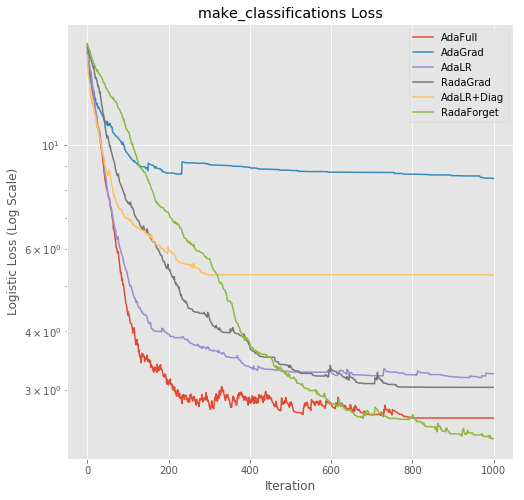

In [537]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=True, figsize = (8,8)
)

plt.plot(np.arange(T), adafull_best['losses'], label='AdaFull')
plt.plot(np.arange(T), adagrad_best['losses'], label='AdaGrad')
plt.plot(np.arange(T), adalr_best['losses'], label='AdaLR')
plt.plot(np.arange(T), radagrad_best['losses'], label='RadaGrad')
plt.plot(np.arange(T), adalr_diag_best['losses'], label='AdaLR+Diag')
plt.plot(np.arange(T), radaforget_best['losses'], label='RadaForget')

plt.legend()
plt.title("make_classifications Loss")
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel("Logistic Loss (Log Scale)")
plt.show()

Let us rescale the x-axis to correspond to time taken, so we can get a better feel for how these algorithms really perform

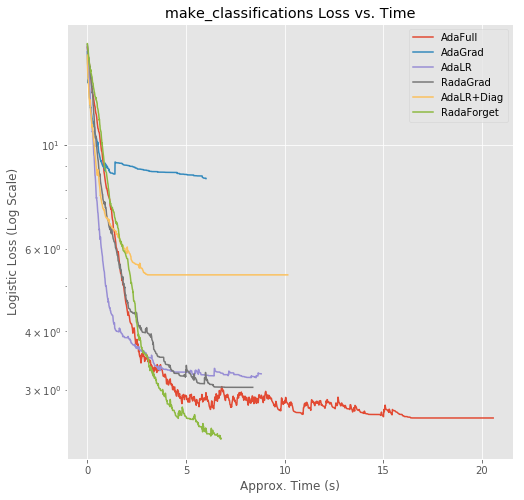

In [538]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.subplots(
    nrows=1, ncols=1, sharex=True, sharey=True, figsize = (8,8)
)

plt.plot((adafull_best['elapsed'] / T) * np.arange(T), adafull_best['losses'], label='AdaFull')
plt.plot((adagrad_best['elapsed'] / T) * np.arange(T), adagrad_best['losses'], label='AdaGrad')
plt.plot((adalr_best['elapsed'] / T) * np.arange(T), adalr_best['losses'], label='AdaLR')
plt.plot((radagrad_best['elapsed'] / T) * np.arange(T), radagrad_best['losses'], label='RadaGrad')
plt.plot((adalr_diag_best['elapsed'] / T) * np.arange(T), adalr_diag_best['losses'], label='AdaLR+Diag')
plt.plot((radaforget_best['elapsed'] / T) * np.arange(T), radaforget_best['losses'], label='RadaForget')

plt.legend()
plt.title("make_classifications Loss vs. Time")
plt.xlabel("Approx. Time (s)")
plt.yscale("log")
plt.ylabel("Logistic Loss (Log Scale)")
plt.show()

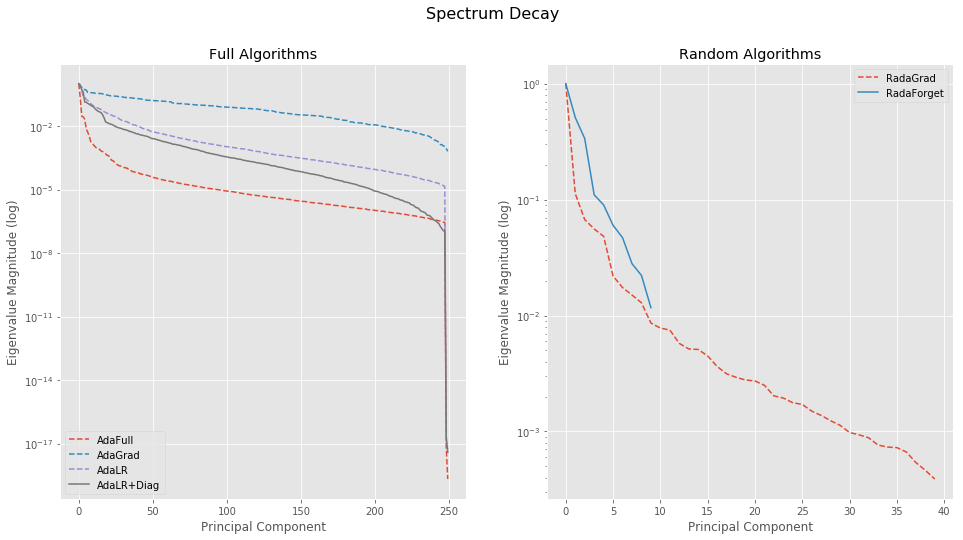

In [360]:
G_adagrad = adagrad_best['G']
G_adalr = adalr_best['G']
G_radagrad = radagrad_best['Gtilde']
G_adalr_diag = adalr_diag_best['G']
G_radaforget = radaforget_best['Gtilde']
G_adafull = adafull_best['G']

s_adafull = np.linalg.svd(G_adafull, compute_uv=False)
s_adafull = s_adafull / np.max(s_adafull)

s_adagrad = np.linalg.svd(np.diag(G_adagrad), compute_uv=False)
s_adagrad = s_adagrad / np.max(s_adagrad)

s_adalr = np.linalg.svd(G_adalr, compute_uv=False)
s_adalr = s_adalr / np.max(s_adalr)

s_radagrad = np.linalg.svd(G_radagrad, compute_uv=False)
s_radagrad = s_radagrad / np.max(s_radagrad)

s_adalr_diag = np.linalg.svd(G_adalr_diag, compute_uv=False)
s_adalr_diag = s_adalr_diag / np.max(s_adalr_diag)

s_radaforget = np.linalg.svd(G_radaforget, compute_uv=False)
s_radaforget = s_radaforget / np.max(s_radaforget)

plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize = (16,8)
)

plt.subplot(1, 2, 1)
plt.plot(sorted(s_adafull, reverse=True), linestyle='--', label='AdaFull')
plt.plot(sorted(s_adagrad, reverse=True), linestyle='--', label='AdaGrad')
plt.plot(sorted(s_adalr, reverse=True), linestyle='--', label='AdaLR')
plt.plot(sorted(s_adalr_diag, reverse=True), label='AdaLR+Diag')
plt.legend()
plt.title("Full Algorithms")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue Magnitude (log)")
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(sorted(s_radagrad, reverse=True), linestyle='--', label='RadaGrad')
plt.plot(sorted(s_radaforget, reverse=True), label='RadaForget')
plt.legend()
plt.title("Random Algorithms")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue Magnitude (log)")
plt.yscale('log')
#plt.xscale('log')

plt.suptitle("Spectrum Decay", fontsize=16)
plt.show()
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=1, hspace=0)

This shows the decay of the eigenvalues of the gradient matrix for all algorithms. Because the randomized algorithms only store the $p\times \tau$ matrix $\tilde{G}_t$, they only have $\tau$ eigenvalues.

It is clear that AdaGrad is the worst performer here; all other variants outperform it significantly. This is due to the nature of the data being classified - AdaGrad will have an exponentially worse dependence on the data dimension than Ada-Full because of the approximation it uses. AdaLR, RadaGrad, and RadaForget do not suffer from this, and instead have regrets comparable to Ada-Full. 

It appears that AdaLR+Diag has the same issue as AdaGrad, even though it utilizes both the diagonal and random approximations. Perhaps decoupling the learning rates would improve performance. However, this would add a nuisance parameter, and probably would still underperform compared to the other variants.

RadaForget is the unambiguous winner here. This is promising, but it must be tested on non-convex problems as well.

In [642]:
def AdaLR_shifted(eta, delta, tau, T, f, fgrad, beta):
    start = time()
    
    p = beta.shape[0]
    S = np.zeros((p, p))
    h = np.zeros(p)
    #Pi = sample_srft(p, tau)
    
    losses = []
    for t in range(T):
        # receive gradient
        g = fgrad(beta)
        # update gradient matrix
        S = S + np.outer(g, g)
        h = h + g
        G = S - np.outer(h, h)
        
        # construct approximate range of G
        # random projection
        # Gproj = G @ Pi
        Gproj = srft_matmul(G, tau)
        # QR decomposition
        Q, R = np.linalg.qr(Gproj)
        
        # approximate SVD using approximate range
        B = Q.T @ G
        U, s, VT = np.linalg.svd(B, full_matrices=False)
                
        # update
        direction = VT.T @ ((1 / (np.sqrt(s) + delta) * (VT @ g)))
        beta = beta - eta * direction
        
        losses.append(f(beta))

    return beta, losses, G, time() - start

In [652]:
# AdaLR_Shifted
adalr_shifted_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    print("eta:", eta)
    for tau in tau_range:
        print("tau:", tau)
        beta_T_adalr_shifted, losses_adalr_shifted, G, elapsed = AdaLR_shifted(100*eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_adalr_shifted[-1] < adalr_shifted_best['loss_best']:
            adalr_shifted_best = {
                'loss_best': losses_adalr_shifted[-1],
                'losses': losses_adalr_shifted,
                'beta': beta_T_adalr_shifted,
                'tau': tau,
                'eta': eta,
                'G': G,
                'elapsed': elapsed
            }
adalr_shifted_best

eta: 0.001
tau: 10
tau: 20
tau: 40
eta: 0.01
tau: 10
tau: 20
tau: 40
eta: 0.1
tau: 10
tau: 20
tau: 40
eta: 1
tau: 10
tau: 20
tau: 40
eta: 10
tau: 10
tau: 20
tau: 40


{'loss_best': 15.23868517630563,
 'losses': [15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.23868517630563,
  15.2386851

In [657]:
from autograd import grad
import autograd.numpy as np
from tqdm import tqdm_notebook

n = 10000
p = 500

eta_range = [0.001, 0.01, 0.1, 1, 10]
delta = 1e-8
tau_range = [10, 20, 40]
T = 1000
beta_0 = np.ones(p)

def log_loss(yhat, y, eps=1e-15):
    yhat = np.clip(yhat, eps, 1 - eps)
    return -(np.inner(y, np.log(yhat)) + np.inner(1 - y, np.log(1 - yhat))) / y.shape[0]

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=n, n_features=p)
def make_loss(X, y):
    def loss(beta):
        return log_loss(X @ beta, y)
    return loss

loss = make_loss(X, y)
lossgrad = grad(loss)

In [ ]:
# AdaFull
adafull_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    beta_T_adafull, losses_adafull, G, elapsed = AdaFull(eta, delta, T, loss, lossgrad, beta_0)
    if losses_adafull[-1] < adafull_best['loss_best']:
        adafull_best = {
            'loss_best': losses_adafull[-1],
            'losses': losses_adafull,
            'beta': beta_T_adafull,
            'eta': eta,
            'G': G,
            'elapsed': elapsed
            }

        
# AdaGrad
adagrad_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    beta_T_adagrad, losses_adagrad, G, elapsed = AdaGrad(eta, delta, T, loss, lossgrad, beta_0)
    if losses_adagrad[-1] < adagrad_best['loss_best']:
        adagrad_best = {
            'loss_best': losses_adagrad[-1],
            'losses': losses_adagrad,
            'beta': beta_T_adagrad,
            'eta': eta,
            'G': G,
            'elapsed': elapsed
            }
        
# AdaLR
adalr_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    for tau in tau_range:
        beta_T_adalr, losses_adalr, G, elapsed = AdaLR(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_adalr[-1] < adalr_best['loss_best']:
            adalr_best = {
                'loss_best': losses_adalr[-1],
                'losses': losses_adalr,
                'beta': beta_T_adalr,
                'tau': tau,
                'eta': eta,
                'G': G,
                'elapsed': elapsed
            }

# RadaGrad
radagrad_best = {
    'loss_best': float('inf')
}
for eta in tqdm_notebook(eta_range):
    for tau in tau_range:
        beta_T_radagrad, losses_radagrad, Gtilde, elapsed = RadaGrad(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_radagrad[-1] < radagrad_best['loss_best']:
            radagrad_best = {
                'loss_best': losses_radagrad[-1],
                'losses': losses_radagrad,
                'beta': beta_T_radagrad,
                'tau': tau,
                'eta': eta,
                'Gtilde': Gtilde,
                'elapsed': elapsed
            }

# AdaLR+Diag
adalr_diag_best = {
    'loss_best': float('inf')
}
for eta in eta_range:
    print(eta)
    for tau in tau_range:
        beta_T_adalr_diag, losses_adalr_diag, G, elapsed = AdaLR_Diag(eta, delta, tau, T, loss, lossgrad, beta_0)
        if losses_adalr_diag[-1] < adalr_diag_best['loss_best']:
            adalr_diag_best = {
                'loss_best': losses_adalr_diag[-1],
                'losses': losses_adalr_diag,
                'beta': beta_T_adalr_diag,
                'tau': tau,
                'eta': eta,
                'G': G,
                'elapsed': elapsed
            }

# RadaForget
radaforget_best = {
    'loss_best': float('inf')
}
alpha_range = [0.9, 0.99, 0.999]
for eta in eta_range:
    print(eta)
    for tau in tau_range:
        for alpha in alpha_range:
            beta_T_radaforget, losses_radaforget, Gtilde, elapsed = RadaForget(eta, delta, tau, alpha, T, loss, lossgrad, beta_0)
            if losses_radaforget[-1] < radaforget_best['loss_best']:
                radaforget_best = {
                    'loss_best': losses_radaforget[-1],
                    'losses': losses_radaforget,
                    'beta': beta_T_radaforget,
                    'tau': tau,
                    'eta': eta,
                    'alpha': alpha,
                    'Gtilde': Gtilde,
                    'elapsed': elapsed
                }
radaforget_best

ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'scipy.linalg._decomp_update.reorth'
ZeroDivisionError: float division


ZeroDivisionError: float division

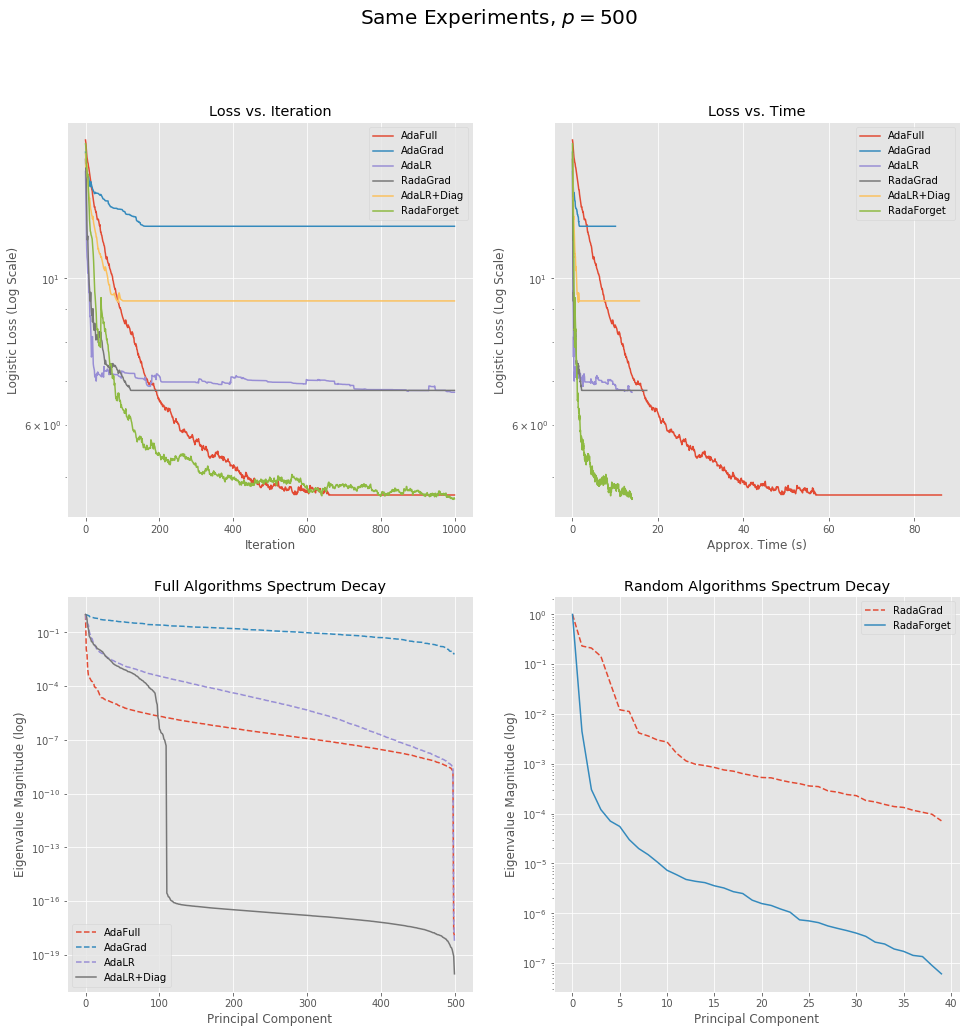

In [663]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# plot on iteration scale
plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=True, figsize = (16,16)
)

plt.subplot(2, 2, 1)
plt.plot(np.arange(T), adafull_best['losses'], label='AdaFull')
plt.plot(np.arange(T), adagrad_best['losses'], label='AdaGrad')
plt.plot(np.arange(T), adalr_best['losses'], label='AdaLR')
plt.plot(np.arange(T), radagrad_best['losses'], label='RadaGrad')
plt.plot(np.arange(T), adalr_diag_best['losses'], label='AdaLR+Diag')
plt.plot(np.arange(T), radaforget_best['losses'], label='RadaForget')

plt.legend()
plt.title("Loss vs. Iteration")
plt.xlabel("Iteration")
plt.yscale("log")
plt.ylabel("Logistic Loss (Log Scale)")

# plot on time scale
plt.subplot(2, 2, 2)
plt.plot((adafull_best['elapsed'] / T) * np.arange(T), adafull_best['losses'], label='AdaFull')
plt.plot((adagrad_best['elapsed'] / T) * np.arange(T), adagrad_best['losses'], label='AdaGrad')
plt.plot((adalr_best['elapsed'] / T) * np.arange(T), adalr_best['losses'], label='AdaLR')
plt.plot((radagrad_best['elapsed'] / T) * np.arange(T), radagrad_best['losses'], label='RadaGrad')
plt.plot((adalr_diag_best['elapsed'] / T) * np.arange(T), adalr_diag_best['losses'], label='AdaLR+Diag')
plt.plot((radaforget_best['elapsed'] / T) * np.arange(T), radaforget_best['losses'], label='RadaForget')

plt.legend()
plt.title("Loss vs. Time")
plt.xlabel("Approx. Time (s)")
plt.yscale("log")
plt.ylabel("Logistic Loss (Log Scale)")

# spectrum decay calculations
G_adagrad = adagrad_best['G']
G_adalr = adalr_best['G']
G_radagrad = radagrad_best['Gtilde']
G_adalr_diag = adalr_diag_best['G']
G_radaforget = radaforget_best['Gtilde']
G_adafull = adafull_best['G']

s_adafull = np.linalg.svd(G_adafull, compute_uv=False)
s_adafull = s_adafull / np.max(s_adafull)

s_adagrad = np.linalg.svd(np.diag(G_adagrad), compute_uv=False)
s_adagrad = s_adagrad / np.max(s_adagrad)

s_adalr = np.linalg.svd(G_adalr, compute_uv=False)
s_adalr = s_adalr / np.max(s_adalr)

s_radagrad = np.linalg.svd(G_radagrad, compute_uv=False)
s_radagrad = s_radagrad / np.max(s_radagrad)

s_adalr_diag = np.linalg.svd(G_adalr_diag, compute_uv=False)
s_adalr_diag = s_adalr_diag / np.max(s_adalr_diag)

s_radaforget = np.linalg.svd(G_radaforget, compute_uv=False)
s_radaforget = s_radaforget / np.max(s_radaforget)

# spectrum decay
plt.subplot(2, 2, 3)
plt.plot(sorted(s_adafull, reverse=True), linestyle='--', label='AdaFull')
plt.plot(sorted(s_adagrad, reverse=True), linestyle='--', label='AdaGrad')
plt.plot(sorted(s_adalr, reverse=True), linestyle='--', label='AdaLR')
plt.plot(sorted(s_adalr_diag, reverse=True), label='AdaLR+Diag')
plt.legend()
plt.title("Full Algorithms Spectrum Decay")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue Magnitude (log)")
plt.yscale('log')

plt.subplot(2, 2, 4)
plt.plot(sorted(s_radagrad, reverse=True), linestyle='--', label='RadaGrad')
plt.plot(sorted(s_radaforget, reverse=True), label='RadaForget')
plt.legend()
plt.title("Random Algorithms Spectrum Decay")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue Magnitude (log)")
plt.yscale('log')
#plt.xscale('log')

plt.suptitle("Same Experiments, $p=500$", fontsize=20)
plt.show()
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=1, hspace=0)

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, RBF

import numpy as np
import matplotlib.pyplot as plt

In [52]:
def f(x):
    return x * np.sin(x)

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()

In [55]:
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [56]:
y_pred, sigma = gp.predict(x, return_std=True)

In [ ]:
from sklearn.gaussian_process.gpr import 

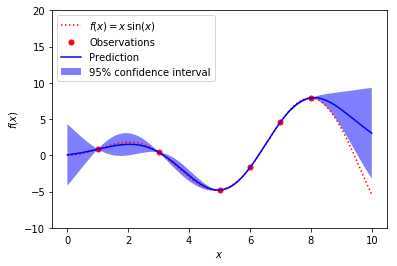

In [61]:
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# Adult Dataset (Sparse)

In [826]:
import pandas as pd

adult = pd.read_csv('/home/tim/Documents/CSCI4971/homework/project/adult.data', header=None)
y = np.zeros(adult.shape[0])
greater = adult[adult.iloc[:, -1] == ' >50K'].index
y[greater] = 1

def encode(col):
    uniq = col.unique()
    xs = np.zeros((len(col), len(uniq)))
    for i, x in enumerate(uniq):
        xs[col == x, i] = 1
    return xs

cols = [encode(adult.iloc[:, i]) for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
X_adult = np.concatenate(cols, axis=1)
del cols

loss_adult = make_loss_reg(X_adult, y)
lossgrad_adult = grad(loss_adult)

beta_adult_adagrad, losses_adult_adagrad, G_adagrad, time_adagrad = AdaGrad(0.1, 1e-8, 1000, loss_adult, lossgrad_adult, np.random.randn(496))
beta_adult_adalr, losses_adult_adalr, G_adalr, time_adalr = AdaLR(0.1, 1e-8, 20, 1000, loss_adult, lossgrad_adult, np.random.randn(496))
beta_adult_adalr_diag, losses_adult_adalr_diag, G_adalr_diag, time_adalr_diag = \
    AdaLR_Diag(0.1, 1e-8, 20, 1000, loss_adult, lossgrad_adult, np.random.randn(496))

In [828]:
beta_adult_radagrad, losses_adult_radagrad, G_radagrad, time_radagrad = \
    RadaGrad(0.1, 1e-8, 20, 1000, loss_adult, lossgrad_adult, np.random.randn(496))
beta_adult_radaforget, losses_adult_radaforget, G_radaforget, time_radaforget = \
    RadaForget(0.1, 1e-8, 20, 0.99, 1000, loss_adult, lossgrad_adult, np.random.randn(496))

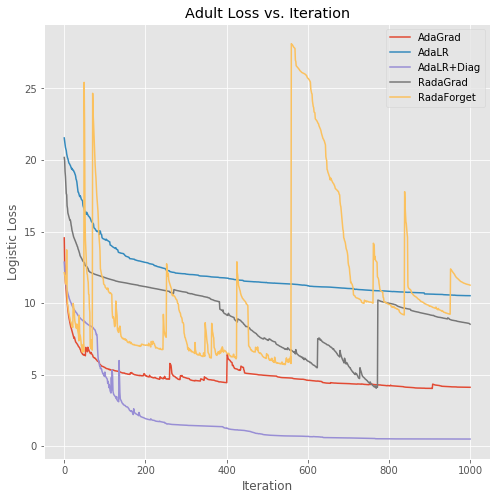

In [829]:
plt.subplots(figsize=(8, 8))

plt.plot(np.arange(1000), losses_adult_adagrad, label='AdaGrad')
plt.plot(np.arange(1000), losses_adult_adalr, label='AdaLR')
plt.plot(np.arange(1000), losses_adult_adalr_diag, label='AdaLR+Diag')
plt.plot(np.arange(1000), losses_adult_radagrad, label='RadaGrad')
plt.plot(np.arange(1000), losses_adult_radaforget, label='RadaForget')

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Logistic Loss")
plt.title("Adult Loss vs. Iteration")
plt.show()

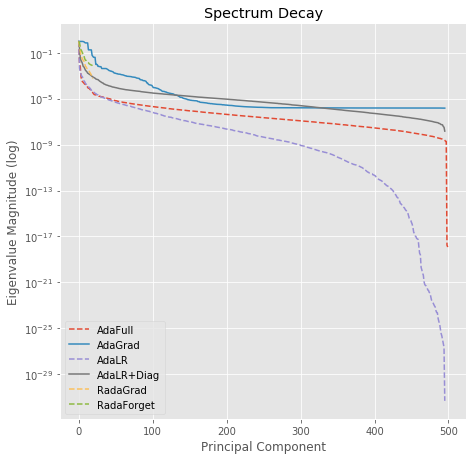

In [832]:
plt.subplots(figsize=(16,16))

s_adagrad = np.linalg.svd(np.diag(G_adagrad), compute_uv=False)
s_adagrad = s_adagrad / np.max(s_adagrad)

s_adalr = np.linalg.svd(G_adalr, compute_uv=False)
s_adalr = s_adalr / np.max(s_adalr)

s_radagrad = np.linalg.svd(G_radagrad, compute_uv=False)
s_radagrad = s_radagrad / np.max(s_radagrad)

s_adalr_diag = np.linalg.svd(G_adalr_diag, compute_uv=False)
s_adalr_diag = s_adalr_diag / np.max(s_adalr_diag)

s_radaforget = np.linalg.svd(G_radaforget, compute_uv=False)
s_radaforget = s_radaforget / np.max(s_radaforget)

# spectrum decay
plt.subplot(2, 2, 3)
plt.plot(sorted(s_adafull, reverse=True), linestyle='--', label='AdaFull')
plt.plot(sorted(s_adagrad, reverse=True), label='AdaGrad')
plt.plot(sorted(s_adalr, reverse=True), linestyle='--', label='AdaLR')
plt.plot(sorted(s_adalr_diag, reverse=True), label='AdaLR+Diag')
plt.plot(sorted(s_radagrad, reverse=True), linestyle='--', label='RadaGrad')
plt.plot(sorted(s_radaforget, reverse=True), linestyle='--', label='RadaForget')
plt.legend()
plt.title("Spectrum Decay")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue Magnitude (log)")
plt.yscale('log')


# Non-Convex Optimization
# CNN

In [50]:
from keras import backend as K
from keras.legacy import interfaces
import numpy as np
import tensorflow as tf
from keras.optimizers import Optimizer
from operator import mul
from functools import reduce
from keras.layers import Lambda

In [3]:
def rect_eye(m, n, dtype=None):
    eye = np.eye(m, n, dtype=dtype)
    return K.constant(eye)

In [ ]:
def srft_vecmul_keras(g, tau):
    

In [12]:
from tensorflow.spectral import dct

In [57]:
class Radagrad(Optimizer):
    """RadaGrad is is derived from the same full gradient matrix of
    AdaGrad, but uses a different approximation. While AdaGrad takes
    the diagonal of the full matrix, RadaGrad utilizes a randomized 
    SVD to approximate the inverse square root."""
    
    def __init__(self, lr, delta, tau, **kwargs):
        super(Radagrad, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.tau = K.variable(tau, dtype='int64', name='tau')
        self.delta = delta
        
    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        
        t = K.cast(self.iterations, K.floatx()) + 1
        
        shapes = [K.int_shape(p) for p in params]
        Gs = [K.variable(K.zeros((reduce(mul, shape, 1), self.tau))) for shape in shapes]
        Qs = [rect_eye(reduce(mul, shape, 1), K.get_value(self.tau)) for shape in shapes]
        Rs = [K.zeros((self.tau, self.tau)) for shape in shapes]
        self.weights = [self.iterations] + Gs + Qs + Rs
        
        for p, g, G, Q, R in zip(params, grads, Gs, Qs, Rs):
            print("Projecting")
            # project gradient
            orig_shape = K.shape(g)
            g = K.flatten(g)
            
            gtilde = srft_vector_multiply(g, K.get_value(self.tau))
            
            print("Updating gradient matrix")
            # update approximate gradient matrix
            print(type(G))
            new_G = G + K.dot(K.reshape(g,      (K.shape(g)[0], 1)), 
                              K.reshape(gtilde, (1, K.shape(gtilde)[0])))
            self.updates.append(K.update(G, new_G))
            
            print("Updating QR")
            # rank-1 qr update
            Q, R = tf.linalg.qr(G)
            #Qnp, Rnp = la.qr_update(K.get_value(Q), K.get_value(R), g, gtilde)
            #new_Q = K.constant(Qnp)
            #new_R = K.constant(Rnp)
            #self.updates.append(K.update(Q, new_Q))
            #self.updates.append(K.update(R, new_R))
            
            print("Computing B")
            # compute approximate range, then approximate SVD
            B = K.dot(K.transpose(new_G), Q)
            print("Computing SVD")
            s, u, w = tf.linalg.svd(B, full_matrices=False)
            
            V = K.dot(Q, K.transpose(w))
            
            print("Computing update")
            # correction term
            gamma = self.lr * (g - np.dot(V, K.dot(K.transpose(V), g)))
            # main direction
            direction = self.lr * K.dot(V, (1 / (K.sqrt(s) + self.delta)) * K.dot(K.transpose(V), g))
            # update
            p = K.flatten(p)
            new_p = p - direction - gamma
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)
                
            new_p = K.reshape(new_p, orig_shape)
            self.updates.append(K.update(p, new_p))
            
        return self.updates
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'tau': int(K.get_value(self.tau)),
                  'delta': self.delta}
        base_config = super(Radagrad, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

from keras.losses import categorical_crossentropy
from keras.optimizers import RMSprop

from keras.datasets import mnist
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [58]:
input_shape = (28, 28, 1)
model = Sequential([
    #Conv2D(32, (5, 5), activation='relu', input_shape=input_shape),
    #MaxPool2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Radagrad(0.1, 1e-8, 500), 
              loss=categorical_crossentropy,
              metrics=['accuracy'])

In [59]:
batch_size = 128
num_epoch = 10
model_log = model.fit(X_train, y_train,
                      verbose=1,
                      validation_data=(X_test, y_test))

ValueError: initial_value must have a shape specified: Tensor("training_14/Radagrad/zeros:0", shape=(7840, ?), dtype=float32)